# Queueing network

## 1 Simulation code

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import heapq
import random

In [2]:
TITLE_SIZE = 14

In [3]:
# Utility min heap implementation
# https://stackoverflow.com/a/8875823
class MyHeap:
    def __init__(self, initial=None, key=lambda x:x):
        self.key = key
        self.index = 0
        if initial:
            self._data = [(key(item), i, item) for i, item in enumerate(initial)]
            self.index = len(self._data)
            heapq.heapify(self._data)
        else:
            self._data = []
            
    def push(self, item):
        heapq.heappush(self._data, (self.key(item), self.index, item))
        self.index += 1
    
    def peek(self):
        return self._data[0][2]
    
    def pop(self):
        return heapq.heappop(self._data)[2]

In [4]:
# We maintain per-server arrival queues to know which server gets the job.
# Note that the arrival queues aren't part of the modeled system at all --
# they're simply a bookkeeping construct for this simulation.
# 
# We maintain per-server wait queues to track per-server queue lengths and
# to know which server gets the job.
class Server:
    def __init__(self, id, params):
        self.id = id
        self.arrival_rate = params["arrival_rate"]
        self.service_rate = params["service_rate"]
        self.routing_cdf = params["routing_cdf"]
        
        # Structure: arrival timestamp
        # We assign job ID at arrival time to main proper order in the Gantt chart.
        self.next_arrival = None
        
        # Queue for jobs waiting for the server. Arrival time supports FCFS discipline.
        # We could have used a linked list here, but a heap implementation makes it easier
        # to apply other priority disciplines later.
        self.wait_queue = MyHeap(key = lambda job : job.arrive_ts)
        
        # Structure: (job_id, start timestamp, departure timestamp)
        self.current_job = None

class Job:
    def __init__(self, id, arrive_ts):
        self.id = id
        self.arrive_ts = arrive_ts

In [5]:
class Simulation:    
    def __init__(self, params, seed):
        self.rng = np.random.default_rng(seed)
        self.params = params
        self.servers = [Server(i, p) for i, p in enumerate(self.params["servers"])]
        
        self.event_df = pd.DataFrame(columns=["timestamp", "job_id", "server_id", "event_type",]).astype(int)
        self.span_df = pd.DataFrame(columns=["job_id", "span_type", "server", "start", "duration",]).astype(int)
        self.job_df = pd.DataFrame(columns=["job_id", "arrival", "departure"]).astype(int)
        
        self.clock = 0.0
        self.job_id = 0
        
        for server in self.servers:
            self._generate_arrival(server)
    
    def _generate_arrival(self, server):
        if server.arrival_rate == 0.0:
            server.next_arrival = float("inf")
        else:
            server.next_arrival = self.clock + self.rng.exponential(scale=1.0/server.arrival_rate)
    
    # Performs a single simulation run.
    # Call this only once. The result of calling it more than once is undefined.
    def run(self, num_jobs):
        while self.job_df.shape[0] < num_jobs:
            self._update_clock()
            self._process_arrivals()
            self._process_starts()
            self._process_departures()
        
        self.job_df["response_time"] = self.job_df["departure"] - self.job_df["arrival"]
        
        results = {
            "params": self.params,
            "span_df": self.span_df,
            "job_df": self.job_df,
        }
        
        SimulationStats(results).dump()
        SimulationPlots(results).plot()
    
    # Find the next clock tick by looking at arrivals and departures.
    def _update_clock(self):
        next_clock = float("inf")
        for server in self.servers:
            if server.next_arrival:
                next_clock = min(next_clock, server.next_arrival)
            if server.current_job:
                next_clock = min(next_clock, server.current_job.depart_ts)
            else:
                if server.wait_queue._data:
                    next_clock = self.clock        
        self.clock = next_clock
    
    # Next arrival -> wait queue
    def _process_arrivals(self):
        for server in self.servers:
            if self.clock >= server.next_arrival:
                job = Job(self.job_id, server.next_arrival)
                self.job_id += 1
                server.wait_queue.push(job)
                self._generate_arrival(server)
                self._log_event(job.id, server.id, "arrival")
                self.job_df = self.job_df.append({
                    "job_id": job.id,
                    "arrival": job.arrive_ts,
                    "departure": None,
                }, ignore_index=True)
    
    # Wait queue -> server
    def _process_starts(self):
        for server in self.servers:
            heap = server.wait_queue._data
            if not server.current_job and heap and self.clock >= server.wait_queue.peek().arrive_ts:
                job = server.wait_queue.pop()
                job.start_ts = self.clock
                job.depart_ts = self.clock + self.rng.exponential(scale=1.0/server.service_rate)
                server.current_job = job
                self._log_event(job.id, server.id, "start")
                self._log_span(job.id, server.id, "wait", job.arrive_ts, job.start_ts)
    
    # Server -> (downstream wait queue or external)
    def _process_departures(self):
        for server in self.servers:
            if server.current_job and self.clock >= server.current_job.depart_ts:
                job = server.current_job
                server.current_job = None
                next_server = self._find_next_server(server)
                if next_server:
                    job.arrive_ts = self.clock
                    next_server.wait_queue.push(job)
                    self._log_event(job.id, server.id, "arrival")
                else:
                    self.job_df.loc[self.job_df["job_id"] == job.id, "departure"] = job.depart_ts                
                self._log_event(job.id, server.id, "departure")
                self._log_span(job.id, server.id, "service", job.start_ts, job.depart_ts)
    
    def _find_next_server(self, src_server):
        x = self.rng.uniform()
        for i in range(len(self.servers)):
            dest_server = self.servers[i]
            if x < src_server.routing_cdf[i]:
                return dest_server
        return None
    
    def _log_event(self, job_id, server_id, event_type):
        self.event_df = self.event_df.append({
            "timestamp": self.clock,
            "job_id": job_id,
            "server_id": server_id,
            "event_type": event_type,
        }, ignore_index=True)
    
    def _log_span(self, job_id, server_id, span_type, start, end):
        self.span_df = self.span_df.append({
            "job_id": job_id,
            "span_type": span_type,
            "server": server_id,
            "start": start,
            "end": end,
            "duration": end - start,
        }, ignore_index=True)

In [6]:
class SimulationStats:
    def __init__(self, results):
        self.params = results["params"]
        self.num_servers = len(self.params["servers"])
        self.span_df = results["span_df"]
        self.util = [self._server_util(i) for i in range(self.num_servers)]
    
    def dump(self):
        print("Utilization:")
        for i in range(self.num_servers):
            print(f"  Server {i}: {self.util[i]:.3f}")
    
    def _server_util(self, server_index):
        total_width = self.span_df.iloc[-1]["end"]
        busy = self.span_df.loc[
            (self.span_df["span_type"] == "service") & (self.span_df["server"] == server_index),
            "duration"].sum()
        return busy / total_width

In [7]:
class SimulationPlots:
    # FIXME This breaks down if there are too many servers
    COLORS = [
        "firebrick",
        "limegreen",
        "steelblue",
        "orange",
        "gold",
    ]
    
    def __init__(self, results):
        self.params = results["params"]
        self.num_servers = len(self.params["servers"])
        self.job_df = results["job_df"]
        self.span_df = results["span_df"]
    
    def plot(self):
        self._plot_jobs_gantt(100)
        self._plot_response_time_histogram()
    
    def _plot_jobs_gantt(self, num_spans):
        df = self.span_df.head(num_spans)

        plt.figure(figsize=(14, 8))
        plt.title("Job schedule (partial view)", size=TITLE_SIZE)
        plt.xlabel("Time")
        plt.ylabel("Job ID")
        for i in range(self.num_servers):
            server_df = df[df["server"] == i]
            wait_df = server_df[server_df["span_type"] == "wait"]
            service_df = server_df[server_df["span_type"] == "service"]
            plt.barh(
                y=wait_df["job_id"],
                left=wait_df["start"],
                width=wait_df["duration"],
                alpha=0.2,
                color=SimulationPlots.COLORS[i])
            plt.barh(
                y=service_df["job_id"],
                left=service_df["start"],
                width=service_df["duration"],
                alpha=1.0,
                color=SimulationPlots.COLORS[i])
        plt.gca().invert_yaxis()
        plt.grid(axis="x")
        plt.show()
    
    def _plot_response_time_histogram(self):
        plt.figure(figsize=(8, 3))
        plt.title("Response time histogram", size=TITLE_SIZE)
        plt.xlabel("Response time")
        plt.ylabel("Count")
        plt.hist(self.job_df["response_time"], bins=31)
        plt.show()

## 2 Simulation run

Utilization:
  Server 0: 0.025
  Server 1: 0.005
  Server 2: 0.080


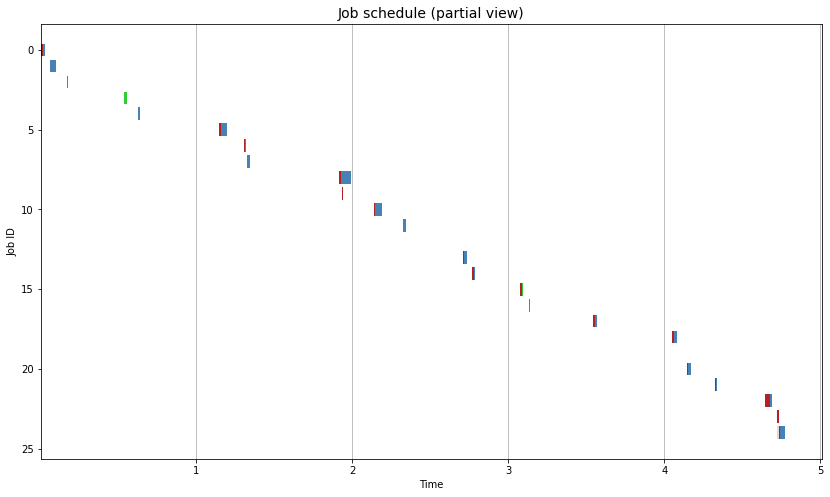

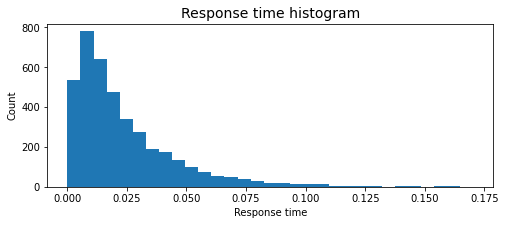

In [8]:
Simulation({
    "servers": [
        { "arrival_rate": 5.0, "service_rate": 200.0, "routing_cdf": [0.0, 0.2, 1.0, 1.0], },
        { "arrival_rate": 0.0, "service_rate": 200.0, "routing_cdf": [0.0, 0.0, 0.0, 1.0], },
        { "arrival_rate": 0.0, "service_rate": 50.0, "routing_cdf": [0.0, 0.0, 0.0, 1.0], },
    ],
}, 142).run(4000)

Utilization:
  Server 0: 0.539
  Server 1: 0.117
  Server 2: 0.284


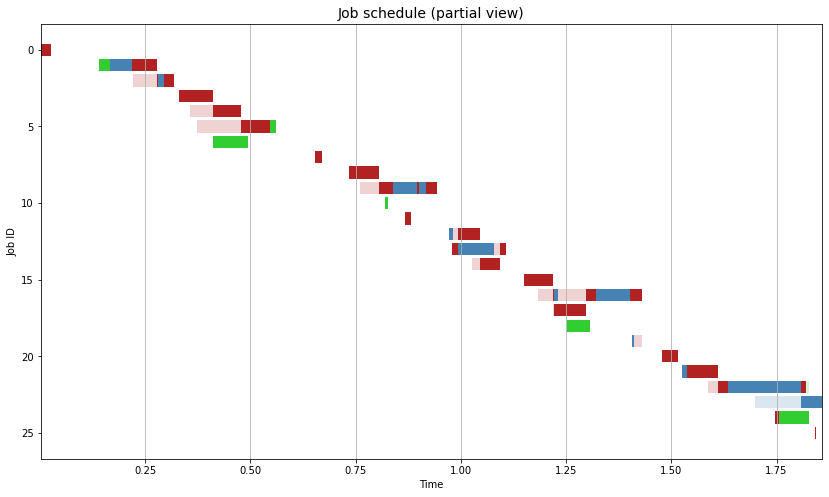

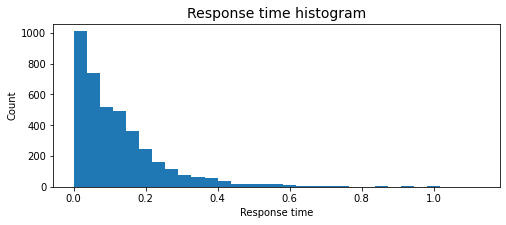

In [9]:
Simulation({
    "servers": [
        { "arrival_rate": 8.0, "service_rate": 32.0, "routing_cdf": [0.0, 0.1, 0.3, 1.0], },
        { "arrival_rate": 2.0, "service_rate": 32.0, "routing_cdf": [0.0, 0.0, 0.5, 1.0], },
        { "arrival_rate": 4.0, "service_rate": 32.0, "routing_cdf": [1.0, 1.0, 1.0, 1.0], },
    ],
}, 142).run(4000)

Utilization:
  Server 0: 0.998
  Server 1: 1.000


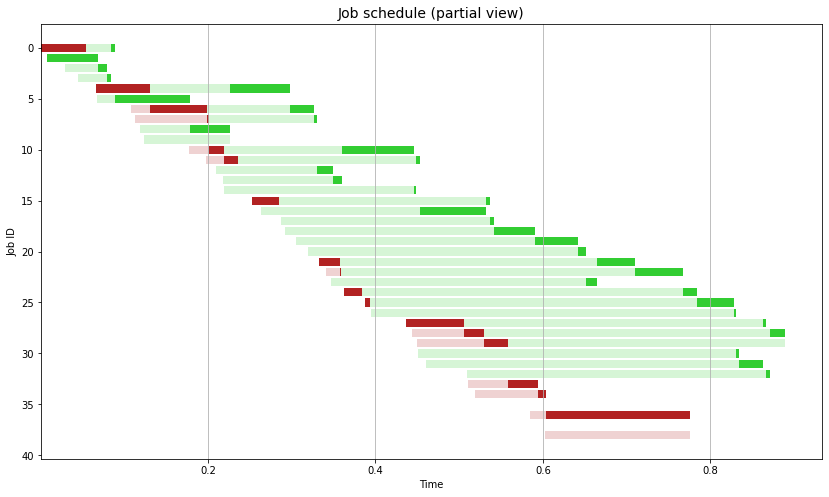

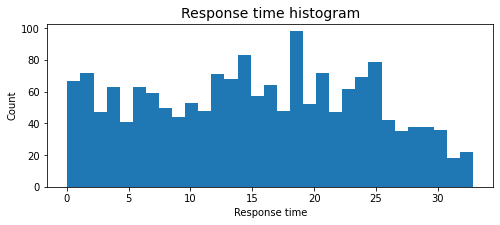

In [10]:
Simulation({
    "servers": [
        { "arrival_rate": 40.0, "service_rate": 32.0, "routing_cdf": [0.0, 1.0, 1.0], },
        { "arrival_rate": 36.0, "service_rate": 32.0, "routing_cdf": [0.0, 0.0, 1.0], },
    ],
}, 142).run(4000)